# Neural style transfer
Inspired from - https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398


# Importing required libraries and defining some constants

In [ ]:
pip install numpy==1.19

     |████████████████████████████████| 14.6 MB 4.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.19.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from collections import OrderedDict
from functools import partial
from random import shuffle
import matplotlib.pyplot as plt
import os
import re

In [ ]:
tf.compat.v1.disable_eager_execution()


In [ ]:
image_size = 224
input_shape = (1, image_size, image_size, 3)

# The VGG network requires the images to be zero mean
# This the mean value of the training data of the ImageNet 
# training set, which will be used to make images zero mean
vgg_mean = [123.68, 116.779, 103.939]

# Hyperparameters used to define the final loss
alpha = 1e3
beta = 1e-3

## Downloading and loading the pretrained VGG-16

In [ ]:
!wget  https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz


--2021-09-12 20:50:25--  https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553436134 (528M)
Saving to: ‘vgg16_weights.npz’

vgg16_weights.npz   100%[===================>] 527.80M  9.31MB/s    in 36s     

2021-09-12 20:51:03 (14.5 MB/s) - ‘vgg16_weights.npz’ saved [553436134/553436134]



In [ ]:
def load_weights(weights_file, end_layer):
    """
    This function loads the weights_file and reads the weights until
    the end_layer is reached.
    """
    
    layers = OrderedDict()
    weights = np.load(weights_file)
    sorted_weights = sorted(weights.items())

    for i, (k, w) in enumerate(sorted_weights):
        # If we have loaded the correct number of layers we stop
        # to save memory
        if sum([1 if len(v)==2 else 0 for v in layers.values()]) >= end_layer:
            break
        
        if k[:-2] not in layers:
            layers[k[:-2]] = {}
            
        if re.search(r'conv\d+_\d+_W', k) is not None:
            layers[k[:-2]]['weights'] = w
            print()
        if re.search(r'conv\d+_\d+_b', k) is not None:
            layers[k[:-2]]['bias'] = w
  
        print('Loading the weights for the layer {} and shape {}'.format(k,w.shape))

    return layers

# Making sure the weights are downloaded
#assert_msg = 'You need to download the vgg16_weights.npz'+\' file by visiting https://www.cs.toronto.edu/~frossard/vgg16/vgg16_weights.npz'+\' and place that in a folder called vgg in your project directory'
#assert os.path.exists(os.path.join('vgg','vgg16_weights.npz')), assert_msg

vgg_layers = load_weights('vgg16_weights.npz',7)


Loading the weights for the layer conv1_1_W and shape (3, 3, 3, 64)
Loading the weights for the layer conv1_1_b and shape (64,)

Loading the weights for the layer conv1_2_W and shape (3, 3, 64, 64)
Loading the weights for the layer conv1_2_b and shape (64,)

Loading the weights for the layer conv2_1_W and shape (3, 3, 64, 128)
Loading the weights for the layer conv2_1_b and shape (128,)

Loading the weights for the layer conv2_2_W and shape (3, 3, 128, 128)
Loading the weights for the layer conv2_2_b and shape (128,)

Loading the weights for the layer conv3_1_W and shape (3, 3, 128, 256)
Loading the weights for the layer conv3_1_b and shape (256,)

Loading the weights for the layer conv3_2_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_2_b and shape (256,)

Loading the weights for the layer conv3_3_W and shape (3, 3, 256, 256)
Loading the weights for the layer conv3_3_b and shape (256,)


### Defining functions to build the style transfer network
- functions that will help to fully define the computational graph of the CNN given an input. 
### Creating TensorFlow variables


In [ ]:
def define_inputs(input_shape):
    """
    This function defines the inputs (placeholders) and image to be generated (variable)
    """
    
    content = tf.compat.v1.placeholder(name='content', shape=input_shape, dtype=tf.float32)
    style = tf.compat.v1.placeholder(name='style', shape=input_shape, dtype=tf.float32)
    generated = tf.compat.v1.get_variable(name='generated', initializer=tf.random_normal_initializer(), 
                                shape=input_shape, dtype=tf.float32, trainable=True)
    
    return {'content': content, 'style': style, 'generated': generated}


def define_tf_weights():
    """
    This function defines the TensorFlow variables for VGG weights and biases
    """
    
    for k, w_dict in vgg_layers.items():
        w, b = w_dict['weights'], w_dict['bias']
        with tf.compat.v1.variable_scope(k):
            tf.compat.v1.get_variable(name='weights', initializer=tf.constant(w, dtype=tf.float32), trainable=False)
            tf.compat.v1.get_variable(name='bias', initializer=tf.constant(b, dtype=tf.float32), trainable=False)


In [ ]:
def get_vgg_pooling_indices(sorted_layer_ids):
    """
    A pooling layer appears at the end of each convolution group (i.e. conv<group>_<id>_W)
    """
    pool_inds = []
    prev_layer_id = int(sorted_layer_ids[0][4])
    for ki, k in enumerate(sorted_layer_ids):
        layer_id = int(k[4])
        if layer_id != prev_layer_id:
            pool_inds.append(ki-1)
        prev_layer_id = layer_id
    return pool_inds

pool_inds = get_vgg_pooling_indices(list(vgg_layers.keys()))
print('pooling indices are: {}'.format(pool_inds))

pooling indices are: [1, 3]


## Computing the VGG net output

Here you are computing the VGG net output by means of convolution and pooling operations. Note that you are replacing the `tf.nn.max_pool` with the `tf.nn.avg_pool` operation, as `tf.nn.avg_pool` gives better visually pleasing results during style transfer \[1\]. Feel free to experiment with `tf.nn.max_pool` by changing the operation in the function below.

In [ ]:
def build_vggnet(inp, layer_ids, pool_inds, on_cpu=False):
    """ This function computes the output of the full VGGnet """
    outputs = OrderedDict()
    
    out = inp

    for lid in layer_ids:
        with tf.compat.v1.variable_scope(lid, reuse= tf.compat.v1.AUTO_REUSE):
            print('Computing outputs for the layer {}'.format(lid))
            w, b = tf.compat.v1.get_variable('weights'), tf.compat.v1.get_variable('bias')
            out = tf.compat.v1.nn.conv2d(filter=w, input=out, strides=[1,1,1,1], padding='SAME')
            out = tf.nn.relu(tf.nn.bias_add(value=out, bias=b))
            outputs[lid] = out

        if lid in pool_inds:
            with tf.name_scope(lid.replace('conv','pool')):
                out = tf.nn.avg_pool(input=out, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')
                outputs[lid.replace('conv','pool')] = out

    return outputs

## Loss functions

### Content cost function
The content cost function is making sure that the content present in the content image is captured in the generated image. It has been found that CNNs capture information about content in the higher levels, where the lower levels are more focused on individual pixel values \[1\]. Therefore we use the top-most CNN layer to define the content loss function. 

In [ ]:

def define_content_loss(inputs, layer_ids, pool_inds, c_weight):

    c_outputs = build_vggnet(inputs["content"], layer_ids, pool_inds)
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)

    content_loss = c_weight * tf.reduce_mean(0.5*(list(c_outputs.values())[-1] - list(g_outputs.values())[-1])**2)
    
    return content_loss

### Style loss function

Defining the style loss function requires more work. To extract the style information from the VGG network, we use all the layers of the CNN. Furthermore, style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. 

In [ ]:
def define_style_matrix(layer_out):
    """
    This function computes the style matrix, which essentially computes
    how correlated the activations of a given filter to all the other filers.
    Therefore, if there are C channels, the matrix will be of size C x C
    """
    n_channels = layer_out.get_shape().as_list()[-1]
    unwrapped_out = tf.reshape(layer_out, [-1, n_channels])
    style_matrix = tf.matmul(unwrapped_out, unwrapped_out, transpose_a=True)
    return style_matrix

def define_style_loss(inputs, layer_ids, pool_inds, s_weight, layer_weights=None):
    """
    This function computes the style loss using the style matrix computed for
    the style image and the generated image
    """
    c_outputs = build_vggnet(inputs["style"], layer_ids, pool_inds)
    g_outputs = build_vggnet(inputs["generated"], layer_ids, pool_inds)
    
    c_grams = [define_style_matrix(v) for v in list(c_outputs.values())]
    g_grams = [define_style_matrix(v) for v in list(g_outputs.values())]
    
    if layer_weights is None:
        style_loss =  s_weight * \
            tf.reduce_sum([(1.0/len(layer_ids)) * tf.reduce_mean((c - g)**2) for c,g in zip(c_grams, g_grams)])
    else:
        style_loss = s_weight * \
            tf.reduce_sum([tf.gather(layer_weights, i) * 0.5 * \
                            tf.reduce_mean((c - g)**2) for i,(c,g) in enumerate(zip(c_grams, g_grams))])
    
    return style_loss

## Defining the optimizer

Next you use the Adam optimizer to optimize the loss of the network.

In [ ]:
def define_optimize(loss, learning_rate = 5.0):
    
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
    opt_op = opt.minimize(loss)
    return opt_op

# The tf.data input pipeline

Here you will be defining an input pipeline, to read a set of given images, do a bit of preprocessing and define an iterator which will produce these preprocessed images one by one.

## Let's see an image
Let us visualize an image and see if they are okey.

(-0.5, 739.5, 409.5, -0.5)

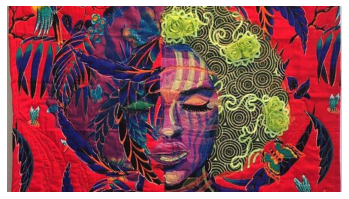

In [ ]:
plt.imshow(Image.open(os.path.join('data','style_1.jpg')))
plt.axis('off')

## Defining the input pipeline

Here you define the full input pipeline. [`tf.data`](https://www.tensorflow.org/guide/datasets) provides a very easy to use and intuitive interface to implementing input pipelines. For most of the image manipulation tasks you can use the [`tf.image`](https://www.tensorflow.org/api_guides/python/image) API, however the ability of `tf.image` to handle dynamic sized images is very limited. For example, if you want to dynamically crop and resize images it is better to do in the form of a generator as implemented below. 

You have defined two input pipelines; one for content and one for style. The content input pipeline looks for `jpg` images that start with the word `content_`, where the style pipeline looks for images starting with `style_`. 

In [ ]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession(config = tf.compat.v1.ConfigProto(allow_soft_placement=True))


def image_gen_func(data_dir, file_match_str, do_shuffle=True):
    """
    This function returns a processed image and the color channel mean values.
    This is a generator function used by the tf.data api.
    """
    
    # Loading filenames
    files = [f for f in os.listdir(data_dir) if f.startswith(file_match_str)]
    if do_shuffle:
        shuffle(files)
    
    mean = np.array([[vgg_mean]])
    
    # For each file preprocess the images and yield
    for f in files:
        img = Image.open(os.path.join(data_dir, f))
        
        width, height = img.size
        
        # We crop the image to a square by cropping on the longer axis
        if width < height:
            left,right = 0, width
            top, bottom = (height-width)/2, ((height-width)/2) + width
        elif width > height:
            top, bottom = 0, height
            left, right = (width - height)/2, ((width-height)/2) + height
        else:
            arr = np.array(img.resize((image_size,image_size))).astype(np.float32)
            yield (arr, mean)
        
        arr = np.array(img.crop((left, top, right, bottom)).resize((image_size,image_size))).astype(np.float32)
        yield (arr, mean)
    

def load_images_iterator(gen_func, zero_mean=False):
    """
    This function returns a dataset iterator of tf.data API
    """
    image_dataset = tf.data.Dataset.from_generator(
        gen_func, 
        output_types=(tf.float32, tf.float32), 
        output_shapes=(tf.TensorShape(input_shape[1:]), tf.TensorShape([1, 1, 3]))
    )
    
    # If true, the mean will be subtracted
    if zero_mean:
        image_dataset = image_dataset.map(lambda x,y: (x - y, y))
    
    # We get on image at a time in a single batch
    image_dataset = image_dataset.batch(1)
    # Defining the iterator
    iterator = tf.compat.v1.data.make_one_shot_iterator(image_dataset)
    return iterator

# Defining partial functions to used by the tf.data.Dataset.from_generator()
part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=False)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=False)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


## Making sure the iterator is working
Let us get a single image from the two iterators and see if they are properly working.

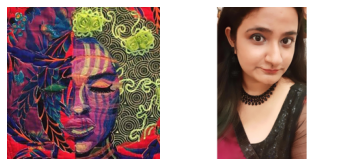

In [ ]:
next_style_image = style_iter.get_next()
next_content_image = content_iter.get_next()

plt.subplot(1,2,1)
plt.imshow(sess.run(next_style_image[0][0]/255.0))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sess.run(next_content_image[0][0]/255.0))
plt.axis('off')

sess.close()

# Defining the computational graph
Now you are ready to rock and roll! In this section you will be defining the full computational graph.
* Define iterators that provide inputs
* Define inputs and CNN variables
* Define the content, style and the total loss
* Define the optimization operation

In [ ]:
tf.compat.v1.reset_default_graph()

config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.InteractiveSession(config=config)

# 1. Defining the input pipeline
part_style_gen_func = partial(image_gen_func, 'data', "style_")
part_content_gen_func = partial(image_gen_func, 'data', "content_")

style_iter = load_images_iterator(part_style_gen_func, zero_mean=True)
content_iter = load_images_iterator(part_content_gen_func, zero_mean=True)

# 2. Defining the inputs and weights
inputs = define_inputs(input_shape)
define_tf_weights()

layer_ids = list(vgg_layers.keys())

# gen_ph is used to initialize the generated image with the pixel values 
# of the content image. You are welcome to try initializing with white noise
# or the style image. The init_generated gives the initialization operation
gen_ph = tf.compat.v1.placeholder(shape=input_shape, dtype=tf.float32)
init_generated = tf.compat.v1.assign(inputs["generated"], gen_ph)

# 3. Losses
# 3.1 Content loss
c_loss = define_content_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, c_weight=alpha
)

# 3.2 Style loss
layer_weights_ph = tf.compat.v1.placeholder(shape=[len(layer_ids)], dtype=tf.float32, name='layer_weights')
s_loss = define_style_loss(
    inputs=inputs, 
    layer_ids=layer_ids, pool_inds=pool_inds, s_weight=beta, layer_weights=None
)

# 3.3 Total loss
tot_loss = c_loss + s_loss

# 4. Optimizer
optimize = define_optimize(tot_loss)

Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2
Computing outputs for the layer conv3_1
Computing outputs for the layer conv3_2
Computing outputs for the layer conv3_3
Computing outputs for the layer conv1_1
Computing outputs for the layer conv1_2
Computing outputs for the layer conv2_1
Computing outputs for the layer conv2_2


# Running style transfer

Time to run the computational graph and generate some artwork. The generated artwork will be saved to `data/gen_0`, `data/gen_1`, ..., `data/gen_5`, etc. folders.

In [ ]:
def save_image_with_restore(image, img_mean, save_path):
    """ This function saves an image to disk """
    
    image_restored = image + img_mean
    image_restored = np.clip(image_restored,0,255.0)
    image_restored = image_restored.astype('uint8')
    Image.fromarray(image_restored).save(save_path)
    
    
def get_layer_weights(type_id, num_layers):
    """
    This function returns different layer weight schemes
    to be experimented with. 
    """
    
    if type_id == 0:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
    if type_id == 1:
        weights = np.arange(1,num_layers+1)**1.5
        weights = weights/np.sum(weights)
        weights = weights[::-1]
        
    return weights

In [ ]:
#del vgg_layers # Releasing memory

n_iter = 500 # Number of optimizations steps per image


for j in range(10):
    print('\nProcessing the {}th image ...'.format(j+1))
    tf.compat.v1.global_variables_initializer().run()
    (cont, cont_mean), (style, style_mean) = sess.run([content_iter.get_next(), style_iter.get_next()])
    
    # Saving the content and style images to disk
    if not os.path.exists(os.path.join('data','gen_{}'.format(j))):
        os.mkdir(os.path.join('data', 'gen_{}'.format(j)))
    save_image_with_restore(cont[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'content.jpg'))
    save_image_with_restore(style[0], style_mean[0], os.path.join('data', 'gen_{}'.format(j),'style.jpg'))
    
    # Initialize the generated image with the values of the content image
    sess.run(init_generated, feed_dict={gen_ph:cont})
    for i in range(n_iter):

        l, _ = sess.run([tot_loss,optimize], feed_dict={
            inputs["content"]: cont,
            inputs["style"]: style,
            layer_weights_ph: get_layer_weights(0, len(layer_ids))
        })

        # Printing out results and saving the generated image
        if (i+1)%50==0:
            print('\tLoss at iteration {}: {}'.format(i+1, l))
            gen_image = sess.run(inputs["generated"])
            save_image_with_restore(gen_image[0], cont_mean[0], os.path.join('data', 'gen_{}'.format(j),'gen_{}.jpg'.format(i+1)))



Processing the 1th image ...
	Loss at iteration 50: 240388229038080.0
	Loss at iteration 100: 83520311525376.0
	Loss at iteration 150: 41592731729920.0
	Loss at iteration 200: 24298733436928.0
	Loss at iteration 250: 15762868666368.0
	Loss at iteration 300: 11092765966336.0
	Loss at iteration 350: 8308913602560.0
	Loss at iteration 400: 6537272623104.0
	Loss at iteration 450: 5344066535424.0
	Loss at iteration 500: 4497083990016.0

Processing the 2th image ...


OutOfRangeError: ignored

In [ ]:
!zip -r /content/gen_data.zip /content/data

updating: content/data/ (stored 0%)
updating: content/data/style_1.jpg (deflated 1%)
updating: content/data/.ipynb_checkpoints/ (stored 0%)
updating: content/data/content_1.jpg (deflated 7%)
updating: content/data/gen_0/ (stored 0%)
updating: content/data/gen_0/style.jpg (deflated 1%)
updating: content/data/gen_0/gen_350.jpg (deflated 1%)
updating: content/data/gen_0/gen_200.jpg (deflated 1%)
updating: content/data/gen_0/content.jpg (deflated 5%)
updating: content/data/gen_0/gen_150.jpg (deflated 1%)
updating: content/data/gen_0/gen_450.jpg (deflated 1%)
updating: content/data/gen_0/gen_100.jpg (deflated 1%)
updating: content/data/gen_0/gen_400.jpg (deflated 1%)
updating: content/data/gen_0/gen_300.jpg (deflated 1%)
updating: content/data/gen_0/gen_50.jpg (deflated 1%)
updating: content/data/gen_0/gen_500.jpg (deflated 1%)
updating: content/data/gen_0/gen_250.jpg (deflated 1%)


# Conclusion

In this tutorial, you learnt about neural style transfer. Neural style trasnfer allows to blend two images (one containing content and one containing style) together to create new art. You first went through why you need neural style transfer and an overview of the architecture of the method. Then you defined the specifics of the neural style transfer network with TensorFlow. Specifically, you defined several functions to define the variables/inputs, compute the VGG output, compute the losses and perform the optimization. You next understood the two losses that allow us to achieve what we want; the content loss and the style loss in detail, and saw how they come together to define the final loss. Finally you ran the model and saw artwork generated by the model.

# Further reading

[\[1\] A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 

[\[2\] Tensorflow Tutorial on Neural Style Transfer](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)